# Star/Galaxy/QSO Classification in DECaLS
by Stéphanie Juneau, Robert Nikutta, Knut Olsen and the NOAO Data Lab Team


In this notebook, we investigate the optical and infrared colors of astronomical sources detected in the DECam Legacy Survey (DECaLS), which comprises stars, galaxies and quasars (or QSOs, which stands for Quasi-Stellar Objects). We will plot color combinations, and take into account the source "type" as defined from the light profile shape.


DECaLS will cover ~9500 deg² in the g, r, z bands to depths of g=24.7, r=23.9, z=23.0. Infrared WISE data are also extracted at the location of the DECaLS sources.

The third data release (DR3) includes a portion of DECaLS, covering a disjoint footprint with 4300 deg² in g-band, 4600 deg² in r-band and 8100 deg² in z-band, of which 4200 deg² has been observed in all three optical filters.

You can read more about DECaLS on the Data Lab survey page [(here)](http://datalab.noao.edu/decals/ls.php) and on the team website [(here)](http://legacysurvey.org).

# Import and Authenticate

In [57]:
# Import packages including some Data Lab (dl) specific ones.
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from astropy.utils.data import download_file  #import file from URL
from scipy.stats import binned_statistic_2d
%matplotlib inline

from dl import helpers

from astropy.table import Table
print 'Done importing'

Q = helpers.Querist('anonymous')

Done importing
Authentication successful.


# Introduction

*Ellipticals are red; Spirals are blue.*

An imaging survey includes a zoo of different astronomical objects. There are foreground stars from our own Milky Way galaxies, and background galaxies at various distances, including QSOs (quasi-stellar objects) with actively accreting supermassive black holes.

<figure>
<img src="Figs/DECaLS_noLabels.jpg", align="center", width=700>
<figcaption>**Figure 1.** Small section of the DECaLS DR3 image from the Legacy Survey [viewer](http://legacysurvey.org/viewer) around RA=253.3, Dec=29.2 degrees.</figcaption>
</figure>


In preparation for DESI ([Dark Energy Spectroscopic Experiment](http://desi.lbl.gov)), the imaging Legacy Survey (including DECaLS) will be used to select over 30 million targets for the spectroscopy campain. The main DESI sample will comprise emission-line galaxies (ELGs), luminous red galaxies (LRGs), and QSOs. There will also be a Bright Galaxy Survey (BGS) targetting a magnitude-limited sample (r<19.5), including stars within the Milky Way.

<figure>
<img src="Figs/DECaLS_Labels.jpg", align="center", width=700>
<figcaption>**Figure 2.** Same section of the DECaLS DR3 image as in Figure 1 but with labels from a preliminary target selection algorithm applied to DR2 observations, and selecting for ELGs (emission-line galaxies), LRGs (luminous red galaxies), and QSOs.</figcaption>
</figure>

## Object Shapes/Types

The object shape (2D light profile) is modeled by [the Tractor](http://thetractor.org) ([Lang, Hogg & Mykytyn](http://adsabs.harvard.edu/abs/2016ascl.soft04008L)) as part of the procedure to compute model photometry.

Possible shapes for DECaLS DR3:
<ul>
<li>PSF (point spread function: size will vary with the seeing of the observations)</li>
<li>SIMP (“simple” galaxies: round, exponential profile with 0.45″ effective radius)</li>
<li>EXP (exponential profile; spiral galaxies)</li>
<li>DEV (deVaucouleurs profile; elliptical galaxies)</li>
<li>COMP (composite deVaucouleurs+exponential at same centroid)</li>
</ul>

<figure>
<img src="Figs/Gals_Qso.jpg", align="left", width=600>
<figcaption>**Figure 3.** Images of galaxies including a nearby elliptical galaxy, a nearby spiral galaxy, and a QSO.</figcaption>
</figure>

Summary of shape fitting and assignment:
<ol>
<li>Fit all sources with PSF and SIMP; keep if significant (5 sigma); otherwise discard.
<li>If SIMP is better model, fit again with EXP and DEV; keep if 3 sigma improvement
<li>Fit again with COMP (composite of EXP and DEV); keep if further 3 sigma improvement
</ol>

## Magnitudes and Colors

Magnitudes are obtained through a set of filters similar to the *u,g,r,i,z* set used for SDSS. In this work, we use:
<ul>
<li>*g,r,z* from the Dark Energy Camera (DECam)
<li>*W1, W2* forced photometry in [WISE](http://www.nasa.gov/mission_pages/WISE/main/) channels 1 & 2 (3.4 and 4.6 microns)
</ul>

Colors are defined as a difference between magnitudes in two bands. A "redder" color means that the object is comparatively brighter in the redder (i.e., longer wavelength) band. Conversely, a "bluer" color means that the object is comparatively brighther in the bluer (i.e., shorter wavelenght) band. 

We will use the following colors: 
<ul>
<li>*g-r*
<li>*r-z*
<li>*z-W1*
<li>*W1-W2*
</ul>

# Query DECaLS Tractor Photometry Catalog

The photometry is derived from Tractor modeling of sources, and the database includes model photometry, type (shape), as well as aperture photometry in various aperture sizes. In this work, we will use Tractor model magnitudes.

In [58]:
# Write query statement (adql)
query = """
        SELECT g as gmag, r as rmag, z as zmag, w1 as w1mag, w2 as w2mag, type,
               decam_flux_2*sqrt(decam_flux_ivar_2) as snr_g, 
               decam_flux_3*sqrt(decam_flux_ivar_3) as snr_r,
               decam_flux_5*sqrt(decam_flux_ivar_5) as snr_z
        FROM ls_dr3.tractor_primary
        WHERE (decam_flux_2*sqrt(decam_flux_ivar_2)>3 and
               decam_flux_3*sqrt(decam_flux_ivar_3)>3 and
               decam_flux_5*sqrt(decam_flux_ivar_5)>3)
        LIMIT 800000"""

#         WHERE (decam_nobs_2>1 and decam_nobs_3>1 and decam_nobs_5>1)

# type         = object type (PSF, SIMP, EXP, DEV, COMP)
# g,r,z        = AB magnitudes in DECam g,r,z bands
# w1,w2        = AB magnitudes in WISE bands W1 & W2
# decam_nobs_X = number of observations in bands g (2), r (3) & z (5)
#
# WHERE: requirement that there are more than 1 (i.e., at least 2) observation in each DECaLS band

print query


        SELECT g as gmag, r as rmag, z as zmag, w1 as w1mag, w2 as w2mag, type,
               decam_flux_2*sqrt(decam_flux_ivar_2) as snr_g, 
               decam_flux_3*sqrt(decam_flux_ivar_3) as snr_r,
               decam_flux_5*sqrt(decam_flux_ivar_5) as snr_z
        FROM ls_dr3.tractor_primary
        WHERE (decam_flux_2*sqrt(decam_flux_ivar_2)>3 and
               decam_flux_3*sqrt(decam_flux_ivar_3)>3 and
               decam_flux_5*sqrt(decam_flux_ivar_5)>3)
        LIMIT 800000


In [60]:
%%time
# Execute the Query
result = Q(query,outfmt='table',preview=3)

Returning Astropy Table
RESULT PREVIEW (3 rows)
gmag,rmag,zmag,w1mag,w2mag,type,snr_g,snr_r,snr_z
24.1962,22.6639,21.9048,22.5193,21.7894,PSF,9.4650337535761,29.0401426685669,18.5437396203499
23.5179,23.3254,22.6295,21.5351,NaN,PSF,15.5442692064805,12.8456014807276,11.1466419414067
24.7034,23.5772,22.6271,21.724,NaN,SIMP,4.20059051645342,8.35848900957508,7.137414875808
CPU times: user 1.63 s, sys: 1.08 s, total: 2.72 s
Wall time: 11.9 s


In [61]:
# Print a few rows from the result table
result[:5]
len(result)

800000

## Optical Color-Color Diagram



In [62]:
# Select range of interest
thres = 5.   #threshold value for S/N
keep = (result['snr_g']>thres)&(result['snr_r']>thres)&(result['snr_z']>thres)

# Colors
g_r   = result['gmag'][keep] - result['rmag'][keep]
r_z   = result['rmag'][keep] - result['zmag'][keep]
z_w1  = result['zmag'][keep] - result['w1mag'][keep]
w1_w2 = result['w1mag'][keep] - result['w2mag'][keep]

print len(g_r)


# Classification per object type
objtype = result['type'][keep]

532640


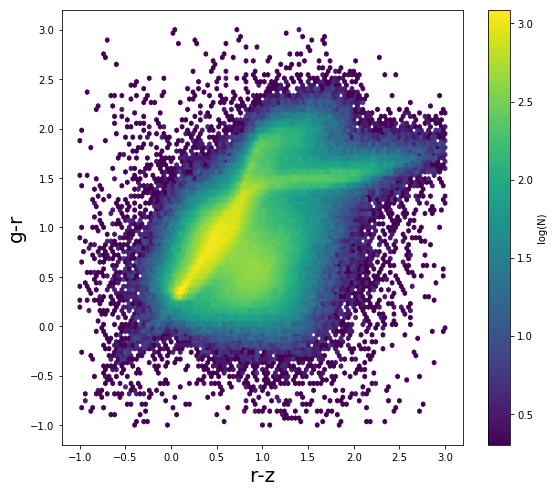

In [63]:
col0 = r_z   #r-z color
col1 = g_r   #g-r color

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col1, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1., 3, -1., 3))
ax1.set_ylabel('g-r',fontsize=20)
ax1.set_xlabel('r-z',fontsize=20)

#color bar
cb = plt.colorbar(im1,label='log(N)')

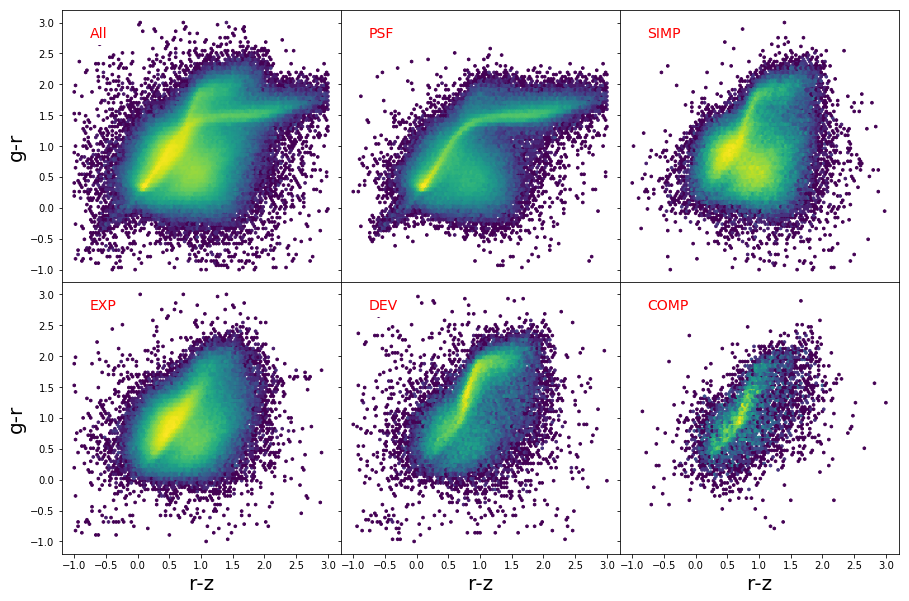

In [64]:
col0 = r_z   #r-z color
col1 = g_r   #g-r color

# List of the types
typeList = ['All','PSF','SIMP','EXP','DEV','COMP']

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex='all', sharey='all')
axes = axes.flatten()

for i,typ in enumerate(typeList):
    ax = axes[i]
    if typ=='All':
        selec = np.ones(len(col0),dtype='bool')   #for All objects: array of 1's
    else:
        selec = (objtype==typ)    #for each type, select on the type parameter
    im = ax.hexbin(col0[selec], col1[selec], bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-1., 3, -1., 3))
    if i>=3: ax.set_xlabel('r-z',fontsize=20)
    if i%3==0: ax.set_ylabel('g-r',fontsize=20)
    ax.text(0.1,0.9,typ,transform=ax.transAxes,fontsize=14,color='red',backgroundcolor='white')

plt.subplots_adjust(wspace=0., hspace=0.)

plt.show()

## Optical-Infrared Colors

Combine information from optical/near-infrared DECam observations and from WISE mid-infrared observations. The latter were extracted using "forced photometry" at the position of DECaLS objects.

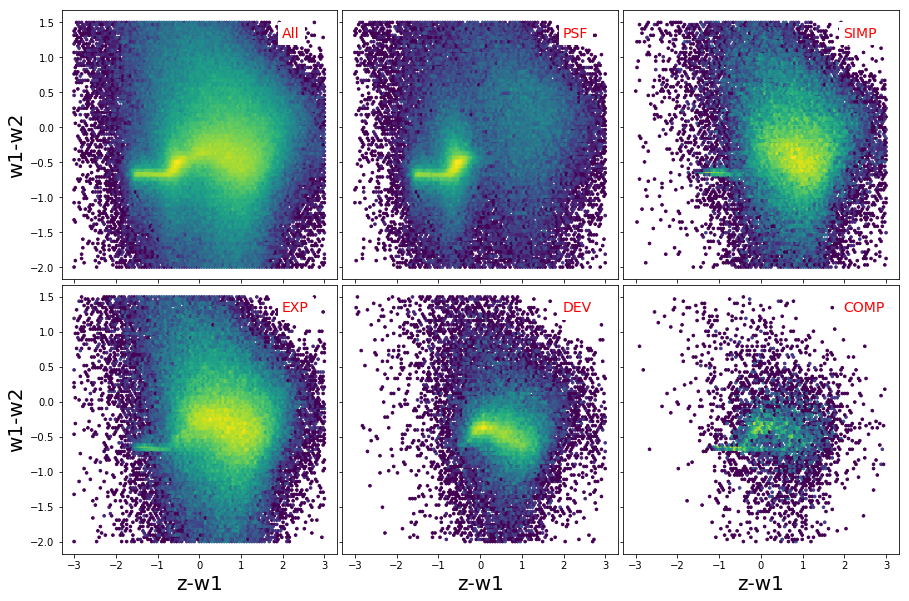

In [65]:
# First, try z-W1 versus infrared color W1-W2
col0 = z_w1
col1 = w1_w2

# List
typeList = ['All','PSF','SIMP','EXP','DEV','COMP']

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex='all', sharey='all')
axes = axes.flatten()

for i,typ in enumerate(typeList):
    ax = axes[i]
    if typ=='All':
        selec = np.ones(len(objtype),dtype='bool')
    else:
        selec = (objtype==typ)
    im = ax.hexbin(col0[selec], col1[selec], bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-3, 3, -2., 1.5))
    if i>=3: ax.set_xlabel('z-w1',fontsize=20)
    if i%3==0: ax.set_ylabel('w1-w2',fontsize=20)
    ax.text(0.8,0.9,typ,transform=ax.transAxes,fontsize=14,color='red',backgroundcolor='white')

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

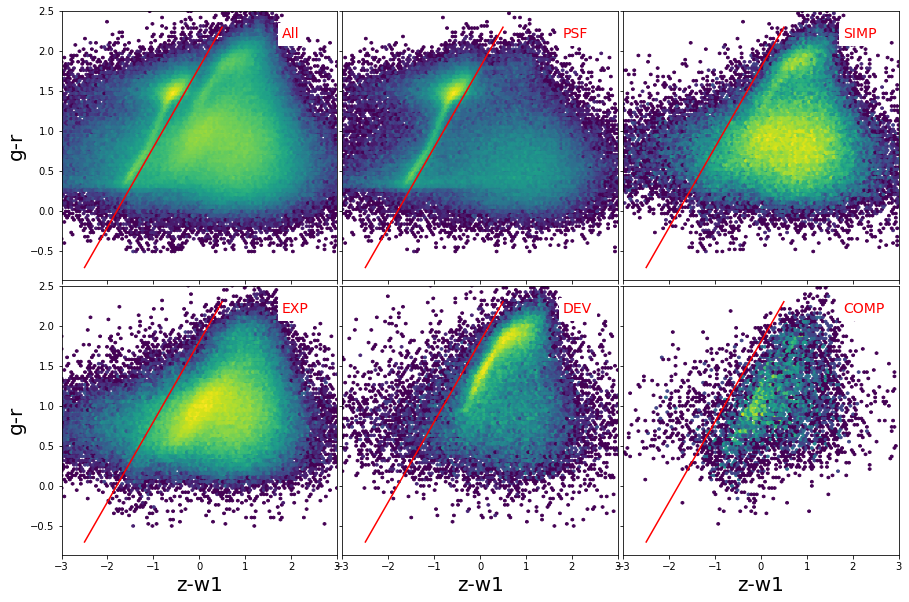

In [66]:
# Combine g-r with z-W1 color (latter has more separation power than W1-W2)
col0 = z_w1
col1 = g_r

# List
typeList = ['All','PSF','SIMP','EXP','DEV','COMP']

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex='all', sharey='all')
axes = axes.flatten()

x = np.arange(4)-2.5

for i,typ in enumerate(typeList):
    ax = axes[i]
    if typ=='All':
        selec = np.ones(len(objtype),dtype='bool')
    else:
        selec = (objtype==typ)
    im = ax.hexbin(col0[selec], col1[selec], bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-3, 3, -0.5, 2.5))
    if i>=3: ax.set_xlabel('z-w1',fontsize=20)
    if i%3==0: ax.set_ylabel('g-r',fontsize=20)
    ax.text(0.8,0.9,typ,transform=ax.transAxes,fontsize=14,color='red',backgroundcolor='white')
    ax.plot(x, 1.0*x+1.8, '-',color='red')

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

## Hack Results

Below is the result of a hack by Bela Abolfathi (UCI) put together during the LSSTC Data Science Fellowship program (April 2017).

<figure>
<img src="Figs/hack1.jpg", align="center", width=700>
<figcaption>**Figure:** Joint query with SDSS SpecObj table and split by CLASS (Star, Galaxy, QSO).</figcaption>
</figure>



Below is the result of a hack by Jan-Torge Schindler (UofA) put together during the NOAO Data Lab Tutorial (May 2017).

<figure>
<img src="Figs/hack2.jpg", align="center", width=500>
<figcaption>**Figure:** Confusion matrix, normalized by number in each category. Done from joint query with SDSS SpecObj to build training sets of Star, Galaxy, QSO. Then classify validation set with Machine Learning (Random Forest).</figcaption>
</figure>



## Image Cutouts for Subset

In [9]:
# Properties for selecting subsamples of interest
objtype = result['type']
col1 = z_w1
w1   = w1mag

# Select interesting subset of points
selec = (objtype=='PSF')&(w1>18)&(w1<19)
red   = (col1>1)&(col1<2)
blue  = (col1>-0.8)&(col1<-0.5)

# Retrieve by position (RA, Dec)
ra  = trac['ra']
dec = trac['dec']

idx = np.arange(ra.size)

# Indices fulfilling both criteria
psf_red = idx[selec&red]
psf_blue = idx[selec&blue]

# Random selection
selec_blue = np.random.choice(psf_blue,6,replace=False)
selec_red  = np.random.choice(psf_red,6,replace=False)

ra_blue  = ra[selec_blue]
dec_blue = dec[selec_blue]

ra_red  = ra[selec_red]
dec_red = dec[selec_red]

zmag_blue = zmag[selec_blue]
w1_blue   = w1[selec_blue]
zmag_red  = zmag[selec_red]
w1_red    = w1[selec_red]

In [10]:
def make_cutout_comparison_table(ra_in, dec_in):
    """
    Produces a table comparing DECaLS and SDSS objects side-by-side
    """    
    de_img = []
    wi_img = []
    
    for i in xrange(len(ra_in)):
        de_cutout_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra=%g&dec=%g&layer=decals-dr3&zoom=15&bands=grz' % (ra_in[i],dec_in[i])
        img = plt.imread(download_file(de_cutout_url,cache=True,show_progress=False,timeout=120))
        de_img.append(img)
        
        wi_cutout_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra=%g&dec=%g&layer=unwise-w1w2&zoom=15' % (ra_in[i],dec_in[i])
        img = plt.imread(download_file(wi_cutout_url,cache=True,show_progress=False,timeout=120))
        wi_img.append(img)

    return de_img,wi_img

In [11]:
def plot_de_wi(de_img,wi_img,zmag,w1mag):
# Plot images in two rows with 6 images in each row
    fig = plt.figure(figsize=(12,4))

    for i in xrange(len(de_img)):
        ax = fig.add_subplot(2,6,i+1)
        ax.imshow(de_img[i])
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.tick_params(axis='both',which='both',length=0)
        ax.text(0.1,0.9,'z=%.1f'%zmag[i],transform=ax.transAxes,fontsize=12,color='white')

        ax = fig.add_subplot(2,6,i+7)
        ax.imshow(wi_img[i])
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.tick_params(axis='both',which='both',length=0)
        ax.text(0.1,0.9,'W1=%.1f'%w1mag[i],transform=ax.transAxes,fontsize=12,color='white')

    plt.subplots_adjust(wspace=0.02, hspace=0.03)

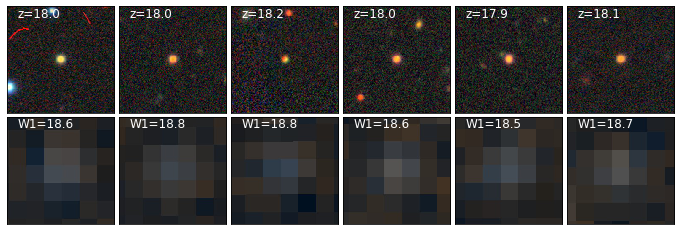

In [12]:
#Plot randomly selected PSF images from the "blue z-W1" side
de_img,wi_img = make_cutout_comparison_table(ra_blue,dec_blue)
plot_de_wi(de_img,wi_img,zmag_blue,w1_blue)

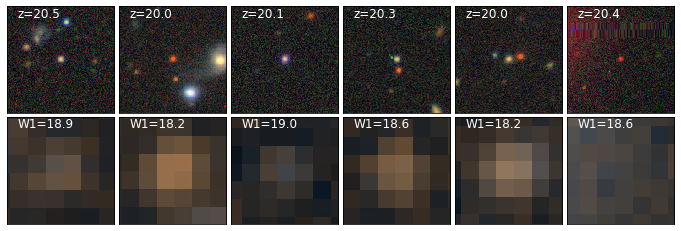

In [13]:
#Plot randomly selected PSF images from the "red z-W1" side
de_img,wi_img = make_cutout_comparison_table(ra_red,dec_red)
plot_de_wi(de_img,wi_img,zmag_red,w1_red)